#### Excle表: 分类 ADMET、预测 ERα_activity、选变量 Molecular_Descriptor

### 第一问

预处理

In [120]:
import numpy as np
import pandas as pd

In [121]:
import matplotlib.pyplot as plt#导入作图库
plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号
plt.figure(figsize=(7,5))#创建图像区域，制定比例
import seaborn as sns

<Figure size 504x360 with 0 Axes>

In [122]:
dataFirst1=pd.read_excel("Molecular_Descriptor.xlsx") #导入分子描述符的training数据集

In [123]:
dataSecond1=pd.read_excel("ERα_activity.xlsx")  #导入pIC50的training数据集

In [124]:
Y=dataSecond1['pIC50']

In [125]:
#查找表格中的全0列
names=[]
for i in range(1,dataFirst1.shape[1]):
    x=sum(dataFirst1.iloc[:,i])
    if x==0:
        names.append(dataFirst1.columns[i])

In [126]:
#删除表格中的全0列
dataFirst1=dataFirst1.drop(names,axis=1)
dataFirst1.shape

(1974, 505)

模型重要性指标选择

In [127]:
from sklearn.ensemble import RandomForestRegressor

In [128]:
#建立随机森林模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestRegressor(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [129]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) MDEC-23                        0.212966
 2) LipoaffinityIndex              0.039376
 3) C1SP2                          0.037159
 4) maxHsOH                        0.030386
 5) minsssN                        0.027593
 6) maxssO                         0.027300
 7) minHsOH                        0.022676
 8) BCUTc-1l                       0.019268
 9) minsOH                         0.018179
10) minHBint5                      0.017632
11) nC                             0.017457
12) MLFER_A                        0.016627
13) nHBAcc                         0.016468
14) SHsOH                          0.013237
15) VC-5                           0.011828
16) ATSc3                          0.011394
17) TopoPSA                        0.010019
18) SHBint10                       0.009138
19) MDEO-12                        0.008050
20) ndssC                          0.006975
21) XLogP                          0.006786
22) MDEC-33                        0.006421
23) ETA_Shape_Y                 

spearman相关系数分析

In [130]:
dataFirst2=dataFirst1.iloc[:,indices[0:50]+1]

In [131]:
result1=dataFirst2.corr("spearman")

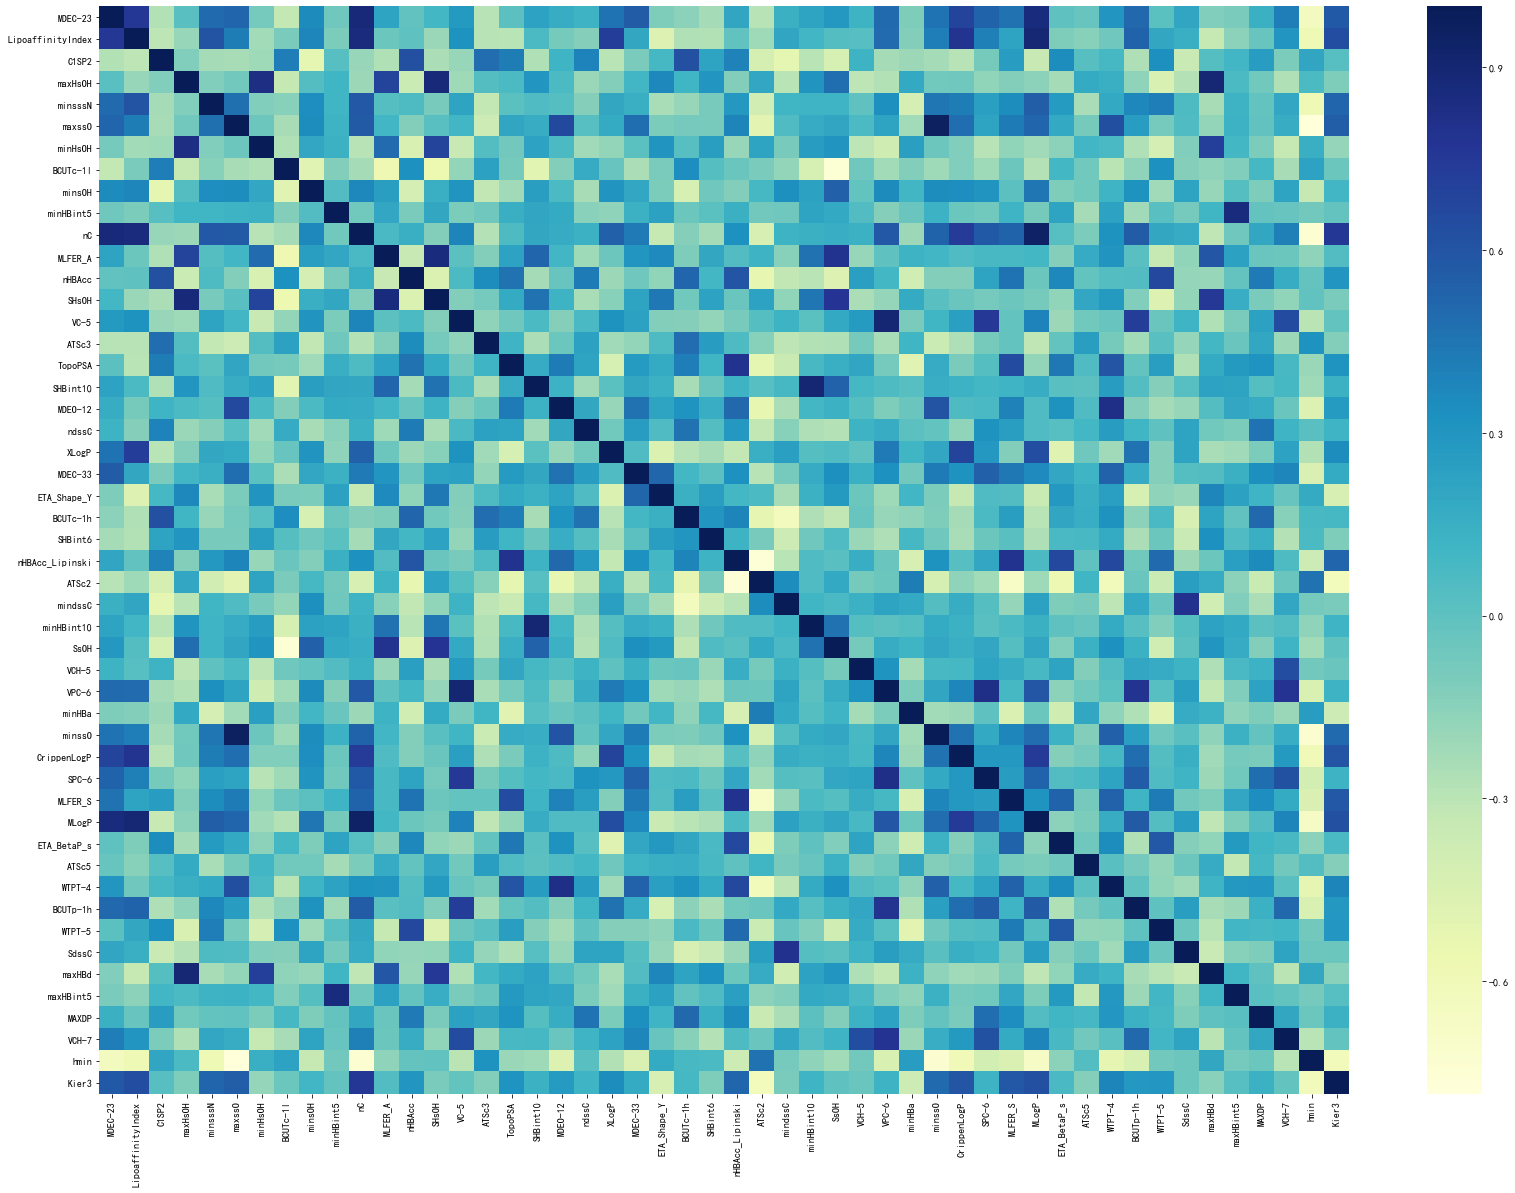

In [135]:
plt.figure(figsize=(28,20))
sns.heatmap(result1,cmap="YlGnBu") #颜色越淡，相关系数越小

In [15]:
#删除自相关系数高的变量
dataFirst3=dataFirst2.drop(['LipoaffinityIndex','nC','CrippenLogP','MLogP','hmin','minsssN','nHBAcc','BCUTc-1h',
'minHsOH','MLFER_A','SHsOH','maxHBd','MDEO-12','minssO','WTPT-4','maxHBint5','Kier3','WTPT-5','VPC-6','BCUTp-1h',
'VCH-7','MLFER_S','minssO','ATSc2','SPC-6'],axis=1)

In [16]:
#删除自相关系数高的变量
dataFirst4=dataFirst3.drop(['ETA_BetaP_s','nHBAcc_Lipinski','SsOH','minHBint10','SdssC','MAXDP'],axis=1)
result=dataFirst4.corr("spearman")

相关系数热力图

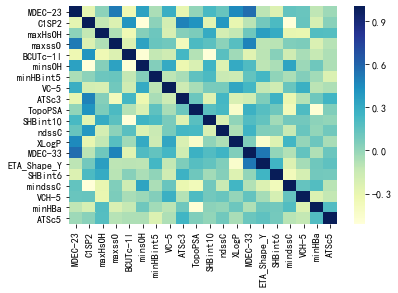

In [17]:
sns.heatmap(result,cmap="YlGnBu") #颜色越淡，相关系数越小

### 第二问

评测标准:MSE、MAPE

In [18]:
#取前17个变量
data=dataFirst4.iloc[:,0:17]

CART回归树

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集
from sklearn import metrics

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
# 创建 CART 回归树
dtr=DecisionTreeRegressor()

# 拟合构造 CART 回归树
dtr.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=dtr.predict(X_test)

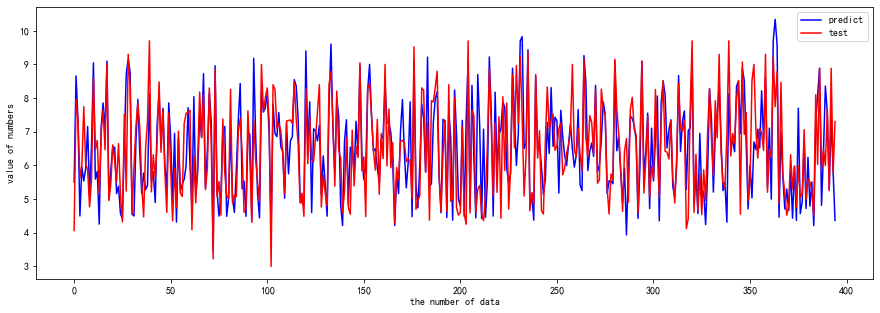

In [22]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [23]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:0.962
平均绝对百分比误差MAPE:11.135%


Xgboost回归

In [24]:
import xgboost as xgb

In [28]:
# 创建xgboost
model=xgb.XGBRegressor(n_estimators=100,random_state=123)

# 拟合构造xgboost
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

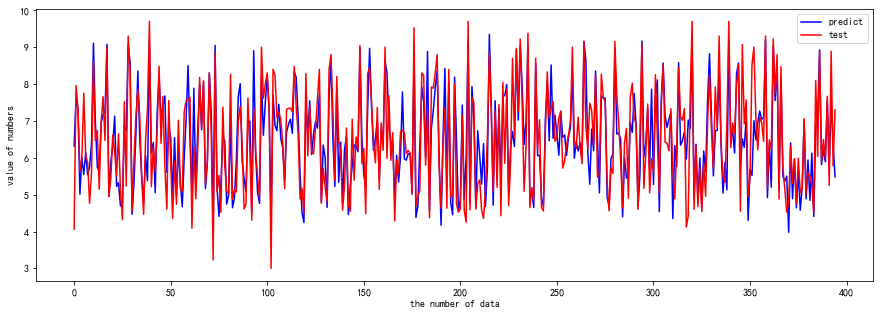

In [29]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [30]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:0.751
平均绝对百分比误差MAPE:9.050%


LightGBM回归

In [31]:
import lightgbm as lgb

In [32]:
# 创建lightgbm
model=lgb.LGBMRegressor(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

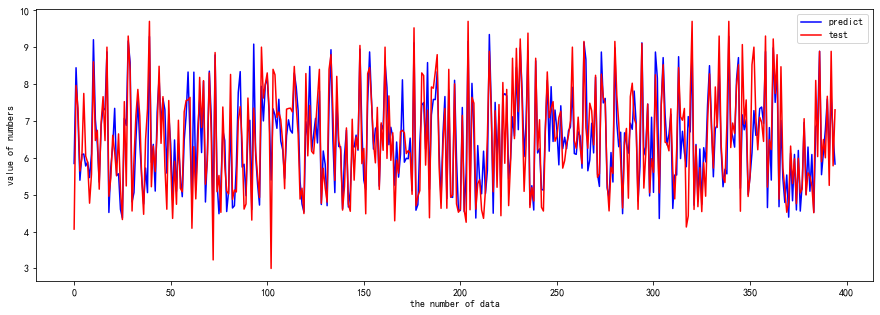

In [33]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [34]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:0.713
平均绝对百分比误差MAPE:8.730%


多元线性回归

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
# 创建LR
model=LinearRegression() 

# 拟合构造LR
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

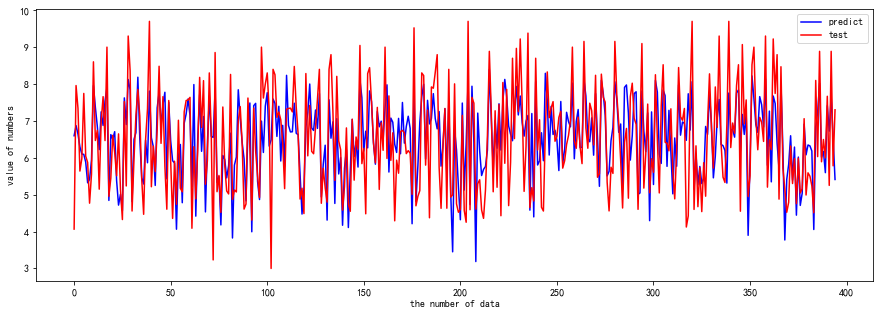

In [37]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_pred)),Y_test,'r',label="test")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [38]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:1.015
平均绝对百分比误差MAPE:13.166%


#### 预测test中的值(选LightGBM)

In [40]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMRegressor(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [41]:
X_test.shape

(395, 17)

In [42]:
data1=pd.read_excel("Molecular_Descriptor.xlsx",sheet_name=1)

In [43]:
#20个筛选变量的列名
names=['MDEC-23','C1SP2','maxHsOH','maxssO','BCUTc-1l','minsOH','minHBint5','VC-5',
'ATSc3','TopoPSA','SHBint10','ndssC','XLogP','MDEC-33','ETA_Shape_Y','SHBint6','mindssC',
'VCH-5','minHBa','ATSc5']                                             

In [44]:
data1=data1.loc[:,names]

In [45]:
data2=data1.iloc[:,0:17] #取前17个变量

In [46]:
x_test=data2 #预测集中的自变量

In [48]:
# 预测 预测集中的因变量值
y_pred=model.predict(x_test)

### 第三问

#### 第一个

重要性指标筛选

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
dataThird1=pd.read_excel("ADMET.xlsx")

In [155]:
Y1=dataThird1['Caco-2']

In [156]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [157]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) nHeavyAtom                     0.031411
 2) ECCEN                          0.025821
 3) ETA_Eta_R_L                    0.025167
 4) Kier1                          0.021926
 5) WPATH                          0.021846
 6) ETA_Alpha                      0.020246
 7) SP-2                           0.019899
 8) VABC                           0.019500
 9) WTPT-1                         0.018472
10) ATSm2                          0.016282
11) MW                             0.015266
12) ATSm3                          0.014972
13) VAdjMat                        0.014565
14) ATSm1                          0.014467
15) SP-1                           0.014095
16) Kier2                          0.013892
17) MDEC-23                        0.013264
18) ETA_Beta                       0.012520
19) ETA_Beta_s                     0.011803
20) CrippenMR                      0.011757
21) SaaO                           0.009244
22) SP-0                           0.009155
23) maxaaO                      

In [158]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5541054716111801

In [159]:
dataFirst5=dataFirst1.iloc[:,indices[0:50]+1]

In [160]:
data=dataFirst5

svm分类

In [161]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y1,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [162]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support

In [163]:
from sklearn import svm
model = svm.SVC(C=80,gamma=0.0001)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

评价指标

In [164]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.860759
精确率Precision:0.883019
召回率Recall:0.906977
F1 score:0.8948374760994262
AUC:0.840350


LightGBM分类

In [242]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMClassifier(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [243]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.860759
精确率Precision:0.845865
召回率Recall:0.941423
F1 score:0.891089108910891
AUC:0.839301


预测test中的值(选SVM)

In [165]:
data1=pd.read_excel("Molecular_Descriptor.xlsx",sheet_name=1)

In [166]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

In [167]:
# 预测 预测集中的因变量值
y_pred=model.predict(x_test)

In [168]:
y_pred #预测值

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

#### 第二个

In [91]:
Y2=dataThird1['CYP3A4']

In [92]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [93]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) ETA_Eta_L                      0.039845
 2) SP-4                           0.033536
 3) VP-3                           0.026159
 4) VP-5                           0.025984
 5) nBondsS                        0.024968
 6) ATSp3                          0.023421
 7) Zagreb                         0.022739
 8) ATSp2                          0.022602
 9) VP-2                           0.018882
10) WPOL                           0.017951
11) VP-1                           0.017333
12) ETA_Alpha                      0.015374
13) ATSp1                          0.014925
14) VP-6                           0.014791
15) VP-7                           0.014331
16) SP-3                           0.013688
17) SP-5                           0.013440
18) VAdjMat                        0.013103
19) nBonds                         0.012898
20) WPATH                          0.012391
21) ETA_Eta_R                      0.010959
22) SP-2                           0.010677
23) nAtom                       

In [94]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.6108749608278902

In [95]:
dataFirst6=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst6

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y2,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [84]:
from sklearn import svm
model = svm.SVC(C=80,gamma=0.0001)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [85]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.860759
精确率Precision:0.802326
召回率Recall:0.644860
F1 score:0.7150259067357513
AUC:0.792916


In [97]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMClassifier(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [98]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.949367
精确率Precision:0.898148
召回率Recall:0.915094
F1 score:0.9065420560747663
AUC:0.938516


预测test中的值(选LightGBM)

In [99]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

# 预测 预测集中的因变量值
y_pred=model.predict(x_test)
y_pred #预测值

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

#### 第三个

In [169]:
Y3=dataThird1['hERG']

In [170]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [171]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) Kier1                          0.026131
 2) ECCEN                          0.021027
 3) VP-1                           0.020746
 4) nHeavyAtom                     0.020639
 5) ETA_Alpha                      0.019470
 6) ETA_Eta_R_L                    0.019349
 7) WPATH                          0.018317
 8) CrippenMR                      0.016969
 9) McGowan_Volume                 0.015979
10) VP-0                           0.015524
11) nBonds2                        0.014605
12) AMR                            0.014071
13) nAtom                          0.014005
14) VABC                           0.013856
15) apol                           0.013760
16) VP-2                           0.013661
17) LipoaffinityIndex              0.013405
18) VAdjMat                        0.013114
19) SP-1                           0.012183
20) Kier2                          0.011985
21) SP-0                           0.011394
22) ATSp1                          0.011019
23) nRotB                       

In [172]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5399855297016459

In [173]:
dataFirst7=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst7

In [174]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y3,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [344]:
from sklearn import svm
model = svm.SVC(C=80,gamma=0.0001)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [345]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.840506
精确率Precision:0.793548
召回率Recall:0.798701
F1 score:0.796116504854369
AUC:0.832961


In [175]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMClassifier(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [176]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.896203
精确率Precision:0.873563
召回率Recall:0.888889
F1 score:0.881159420289855
AUC:0.895337


预测test中的值(选LightGBM)

In [111]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

# 预测 预测集中的因变量值
y_pred=model.predict(x_test)
y_pred #预测值

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1], dtype=int64)

#### 第四个

In [177]:
Y4=dataThird1['HOB']

In [178]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [179]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) BCUTc-1l                       0.036341
 2) SHsOH                          0.023942
 3) maxHsOH                        0.023221
 4) MLFER_A                        0.015725
 5) SsOH                           0.015295
 6) minHsOH                        0.014827
 7) minsOH                         0.013952
 8) nHsOH                          0.013907
 9) nsOH                           0.012511
10) maxsOH                         0.011432
11) minaasC                        0.009021
12) maxHBd                         0.008654
13) SHBd                           0.008337
14) SdO                            0.006999
15) MDEC-23                        0.006990
16) VP-5                           0.006942
17) BCUTp-1l                       0.006277
18) WTPT-5                         0.006166
19) VP-3                           0.006107
20) nHBAcc                         0.005927
21) minssO                         0.005871
22) maxdO                          0.005793
23) hmin                        

In [180]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.39504886652453647

In [181]:
dataFirst8=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst8

In [182]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y4,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [183]:
from sklearn import svm
model = svm.SVC(C=80,gamma=0.0001)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [184]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.779747
精确率Precision:0.823151
召回率Recall:0.888889
F1 score:0.8547579298831386
AUC:0.687435


In [185]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMClassifier(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [186]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{:3f}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.883544
精确率Precision:0.923077
召回率Recall:0.916667
F1 score:0.919861
AUC:0.855530


预测test中的值(选LightGBM)

In [187]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

# 预测 预测集中的因变量值
y_pred=model.predict(x_test)
y_pred #预测值

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

#### 第五个

In [144]:
Y5=dataThird1['MN']

In [145]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [146]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(dataFirst1.shape[1]-1):
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) WTPT-5                         0.042621
 2) WTPT-3                         0.032367
 3) ETA_BetaP_s                    0.025030
 4) nHBAcc_Lipinski                0.023219
 5) ETA_Epsilon_1                  0.022659
 6) TopoPSA                        0.019848
 7) FMF                            0.016475
 8) ETA_dEpsilon_A                 0.014578
 9) ETA_EtaP_F_L                   0.013322
10) nN                             0.013312
11) nHBAcc                         0.012409
12) MLFER_S                        0.011619
13) ETA_BetaP                      0.011456
14) ETA_EtaP_L                     0.011160
15) minHBa                         0.011092
16) MLFER_E                        0.010753
17) maxsCH3                        0.010610
18) ETA_Epsilon_2                  0.010485
19) mindssC                        0.008950
20) ETA_Epsilon_4                  0.008631
21) hmax                           0.008517
22) ETA_Eta_F_L                    0.008466
23) MLFER_BO                    

In [147]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5029288060933234

In [148]:
dataFirst9=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst9

In [149]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y5,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [321]:
from sklearn import svm
model = svm.SVC(C=80,gamma=0.0001)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [322]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.886076
精确率Precision:0.830769
召回率Recall:0.613636
F1 score:0.7058823529411765
AUC:0.788903


In [150]:
import lightgbm as lgb

# 创建lightgbm
model=lgb.LGBMClassifier(n_estimators=100,random_state=123)

# 拟合构造lightbgm
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

In [151]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.962025
精确率Precision:0.944444
召回率Recall:0.860759
F1 score:0.9006622516556292
AUC:0.924051


预测test中的值(选LightGBM)

In [152]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

# 预测 预测集中的因变量值
y_pred=model.predict(x_test)
y_pred #预测值

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0], dtype=int64)

### 第四问

In [4]:
dataFourth1=pd.read_excel("Molecular_Descriptor 筛选表1.xlsx")

In [5]:
#每次贡献度前4次的变量,共20个
names=['SMILES','MDEC-23','LipoaffinityIndex','C1SP2','maxHsOH','nHeavyAtom','ECCEN',
'ETA_Eta_R_L','Kier1','ETA_Eta_L','SP-4','VP-3','VP-5','VP-1','BCUTc-1l',
'SHsOH','MLFER_A','WTPT-5','WTPT-3','ETA_BetaP_s','nHBAcc_Lipinski']

In [6]:
dataResult=dataFourth1.loc[:,names]

In [33]:
dataResult.to_excel("Molecular_Descriptor 筛选表.xls",index=False)

In [7]:
import matplotlib.mlab as mlab
from scipy.stats import norm

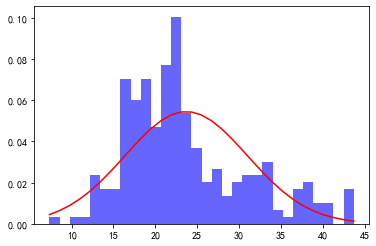

In [119]:
x=dataResult.iloc[:,1] #提取列变量 
mu =np.mean(x) #计算均值 
sigma =np.std(x) #计算标准差
n, bins, patches = plt.hist(x,bins=30,density=1,facecolor='blue',alpha=0.6)
y = norm.pdf(bins, mu, sigma) #拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r') #绘制y的曲线 

（μ-2σ，μ+2σ）

In [118]:
for i in range(1,21):
    x=dataResult.iloc[:,i] #提取列变量 
    mu =np.mean(x) #计算均值 
    sigma =np.std(x) #计算标准差
    print("变量"+names[i]+"的(μ-2σ，μ+2σ）区间: ({},{})".format(round(mu-2*sigma,3),round(mu+2*sigma,3)))

变量MDEC-23的(μ-2σ，μ+2σ）区间: (9.055,38.323)
变量LipoaffinityIndex的(μ-2σ，μ+2σ）区间: (3.208,13.421)
变量C1SP2的(μ-2σ，μ+2σ）区间: (-0.817,1.524)
变量maxHsOH的(μ-2σ，μ+2σ）区间: (0.059,0.893)
变量nHeavyAtom的(μ-2σ，μ+2σ）区间: (13.393,36.006)
变量ECCEN的(μ-2σ，μ+2σ）区间: (-125.558,1158.737)
变量ETA_Eta_R_L的(μ-2σ，μ+2σ）区间: (6.291,17.47)
变量Kier1的(μ-2σ，μ+2σ）区间: (9.215,28.398)
变量ETA_Eta_L的(μ-2σ，μ+2σ）区间: (2.006,9.657)
变量SP-4的(μ-2σ，μ+2σ）区间: (4.257,11.435)
变量VP-3的(μ-2σ，μ+2σ）区间: (2.008,8.11)
变量VP-5的(μ-2σ，μ+2σ）区间: (0.578,4.899)
变量VP-1的(μ-2σ，μ+2σ）区间: (4.142,12.99)
变量BCUTc-1l的(μ-2σ，μ+2σ）区间: (-0.406,-0.305)
变量SHsOH的(μ-2σ，μ+2σ）区间: (-0.157,1.743)
变量MLFER_A的(μ-2σ，μ+2σ）区间: (0.015,1.621)
变量WTPT-5的(μ-2σ，μ+2σ）区间: (-4.155,9.424)
变量WTPT-3的(μ-2σ，μ+2σ）区间: (0.871,22.519)
变量ETA_BetaP_s的(μ-2σ，μ+2σ）区间: (0.55,0.655)
变量nHBAcc_Lipinski的(μ-2σ，μ+2σ）区间: (0.445,6.441)
